In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
if 'notebook_path' not in vars():
    notebook_path = os.getcwd()
os.chdir(os.path.join(notebook_path,"../.."))
sys.path.append(os.getcwd())
import configs.config_eval as config_eval

import numpy as np
import matplotlib.pyplot as plt

import torch, h5py

from src.DatasetTDE import DatasetTDE
import configs.config_train as config_train

In [2]:
from src.DatasetTdoa20201016 import DatasetTdoa20201016
d = DatasetTdoa20201016()
dl = torch.utils.data.DataLoader(d, batch_size=config_train.batch_size)


In [3]:
# exp = "music_0011"
# mics = [0,2]

# if isinstance(exp, str):
#     temp = [i for i,n in enumerate(d.exp_names) if exp == n]
#     if len(temp) == 0:
#         raise Exception("experiment name '" + exp + "' could not be found")
#     exp_i = temp[0]
#     exp_name = exp
# else:
#     exp_i = exp
#     exp_name = d.exp_names[exp]
# #start = d.c_exp_lens[]
# d.times[exp]
# start_i = d.c_exp_lens[exp_i - 1] if exp_i > 0 else 0

# re_sound = d.sounds[exp_name][:,mics]
# re_tdoa = d.gt_toa[exp_name][:,mics[0]] - d.gt_toa[exp_name][:,mics[1]]
# re_time = d.times[exp_name]



In [73]:
sound, tdoa, times = d.get_sequence("music_0014", [0,9])

#model = torch.load("models/ResNetFFT/checkpoints/musan_big_bigger_6.pth")
model = torch.load("models/ResNetFFT/checkpoints/musan_big_22.pth")
model = model.to("cuda:0")
model.eval()

with torch.no_grad():
    X = torch.tensor(sound)
    y = torch.tensor(tdoa)
    X = X.to("cuda")
    pred = model(X).cpu()
    im = pred
    pred = pred.argmax(1) - 500

from models.gcc_phat.gcc_phat import gcc_phat
model_gcc = gcc_phat()
pred_gcc = model_gcc(X.cpu())
pred_gcc = pred_gcc.argmax(1) - 500

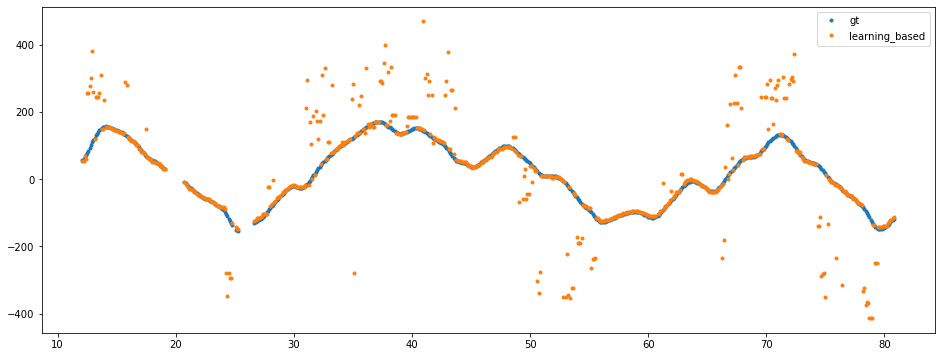

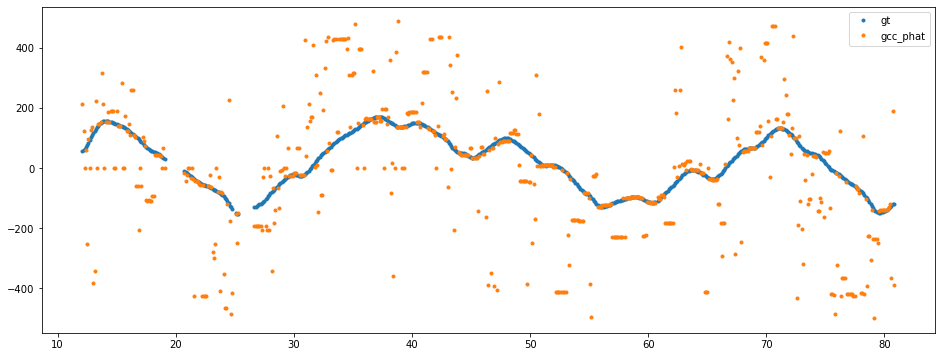

In [84]:
plt.figure(figsize=(16,6))
plt.plot(times,tdoa,'.')
plt.plot(times, pred,'.')
plt.legend(["gt", "learning_based"])


plt.figure(figsize=(16,6))
plt.plot(times,tdoa,'.')
plt.plot(times, pred_gcc,'.')
plt.legend(["gt", "gcc_phat"])
#plt.imshow((im/30).softmax(1).T, aspect="auto")

0.67
0.40


(-200.0, 200.0)

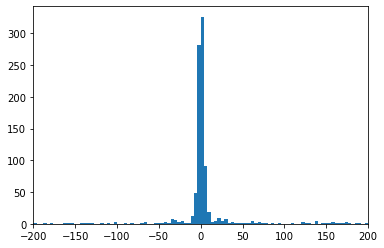

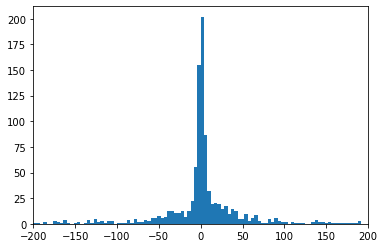

In [93]:
model = torch.load("models/ResNetFFT/checkpoints/musan_big_22.pth")
model = model.to("cuda:0")
dl = torch.utils.data.DataLoader(d, batch_size=int(1e3),shuffle=True)
inlier_lim = 5
width = 200
X,y = next(iter(dl))
X = X.float()
X = X.to("cuda")
pred = model(X).cpu()

#temp = pred.argmax(1)
#temp[temp > 5000] = temp[temp > 5000] - 10000
res = pred.argmax(1) - (y + 500)
#res = temp - y 

plt.hist(res.numpy(),100,range=(-width,width));
inliers = res.abs() < inlier_lim


plt.xlim(-width, width)
print(f'{(sum(inliers)/(inliers).numel()).item():.2f}')

from models.gcc_phat.gcc_phat import gcc_phat
model_gcc = gcc_phat()

pred_gcc = model_gcc(X)
#temp = pred_gcc.argmax(1)
#temp[temp > 5000] = temp[temp > 5000] - 10000
#res_gcc = temp.cpu() - y.cpu()
res_gcc = pred_gcc.argmax(1).cpu() - (y + 500)
plt.figure()
plt.hist(res_gcc.numpy(),100,range=(-width,width));

inliers = res_gcc.abs() < inlier_lim
print(f'{(sum(inliers)/(inliers).numel()).item():.2f}')
plt.xlim(-width,width)

In [85]:
len(d)

384648

In [21]:
torch.fft.fft(X)[:,:,:3000]

tensor([[[-1.0869e+02+0.0000e+00j, -1.6870e+02-2.0389e+01j,
           1.7387e+02+2.2211e+02j,  ...,
          -6.2621e+01+6.9902e+01j,  3.3724e+01+2.2956e+01j,
          -4.3836e+01-1.4332e+01j],
         [-1.2785e+02+0.0000e+00j, -6.4810e+01+2.8416e+01j,
          -1.8794e+02+2.6332e+02j,  ...,
           1.7366e+01-1.5847e+01j, -8.0798e+00+2.4823e+00j,
           1.9216e+01+2.5062e+00j]],

        [[-1.5551e+01+0.0000e+00j,  1.5740e+01-1.5061e+01j,
          -1.4803e+01+1.4101e+01j,  ...,
           5.3547e+00+4.1257e+00j,  2.1063e+00+2.3319e+00j,
          -5.7605e+00-5.0448e-01j],
         [-4.4866e+01+0.0000e+00j, -3.3759e+01-6.6745e+00j,
          -7.3420e+01-1.9217e+01j,  ...,
          -2.1789e+00-2.3595e+00j, -3.2150e-01+1.5967e-01j,
          -2.8305e+00+4.4372e-01j]],

        [[ 6.1549e+01+0.0000e+00j,  3.9689e+01+2.7844e+01j,
           6.4238e+01-7.0490e+01j,  ...,
           4.8907e+00+3.9677e-01j, -8.6168e-02+1.7802e+00j,
           1.8017e+00-4.3836e-01j],
         [ 

In [2]:
torch.manual_seed(37)

# Prepare dataset
dataset =  DatasetTDE(h5py.File(config_train.dataset_path, "r"))
#dataset_train, dataset_val = torch.utils.data.random_split(dataset, [1 - config_train.validation_ratio, config_train.validation_ratio])
dataset_train, dataset_val,_ = torch.utils.data.random_split(dataset, [0.1, 0.05, 0.85])
dl_train = torch.utils.data.DataLoader(dataset_train, batch_size=config_train.batch_size, shuffle=True)

for X,y in dl_train:
    print((y + 500))
    break

tensor([602.1697, 601.5358, 469.4921, 460.3722, 552.1472, 644.2140, 441.1650,
        570.6490, 789.1271, 473.0294, 526.1891, 494.3998, 452.7250, 434.1596,
        471.3704, 261.0381, 428.5178, 562.6719, 497.0912, 523.7046, 488.0297,
        445.7025, 390.7054, 248.4107, 738.7035, 377.9893, 364.8280, 786.4702,
        609.5371, 580.4697, 250.4578, 575.2721, 559.8464, 410.6432, 747.4315,
        720.4678, 463.3182, 704.7195, 366.1852, 479.6798, 526.9223, 493.6669,
        513.2739, 503.3338, 480.9844, 630.4768, 414.1654, 389.1956, 460.5955,
        470.9088, 538.1396, 482.9596, 608.5073, 424.0988, 711.3816, 573.5249,
        536.2204, 462.3165, 423.4047, 399.3473, 424.1585, 539.8633, 507.7585,
        346.0970, 653.3071, 457.6528, 549.2573, 508.4770, 534.3335, 566.1603,
        384.5433, 313.0630, 363.9952, 395.7414, 589.0781, 462.0143, 411.9143,
        496.0849, 479.8661, 339.4586, 553.4696, 646.5519, 578.8339, 419.9632,
        638.5496, 663.4281, 290.7223, 240.8105, 256.5765, 431.93

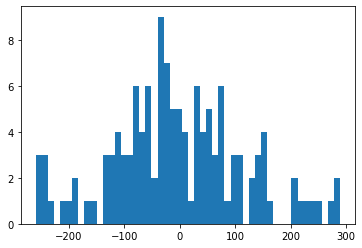

In [3]:
plt.hist(y.numpy(),50);

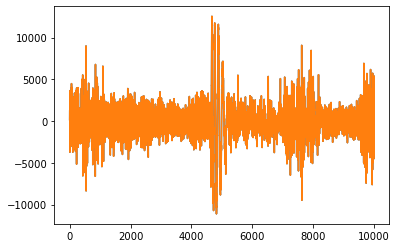

In [4]:
import IPython.display as ipd
i = 9
plt.plot(X[i,0])
x = X + torch.randn(X.shape)*X.std(dim=2,keepdim=True)*torch.rand(X.shape[0]).unsqueeze(1).unsqueeze(2)*config_train.max_measurement_noise_amplitude_ratio*0
plt.plot(x[i,0])
ipd.Audio(x[i,1], rate=16000)

tensor(0.7801)


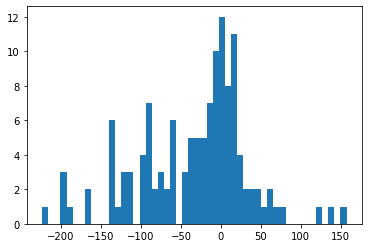

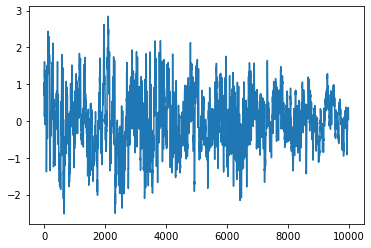

In [41]:
dataset =  DatasetTDE(h5py.File(config_train.dataset_path, "r"))
dl = torch.utils.data.DataLoader(d, batch_size=config_train.batch_size)
#X,y

X,y = next(iter(dl))
#plt.plot(dataset[0][0][1] - dataset[10][0][1])
#plt.plot(dataset.X[6,0])
#plt.plot(X / X.std())
X = X.float()
X = X.to("cuda") 

pred = model(X).argmax(dim=1).cpu()

res = pred - (y + 500)

plt.hist(res.numpy(),50);
plt.figure()
X = X.cpu()
print(X[0,0].std())
X /= X.std(dim=(1,2), keepdim=True) + 1e-5
plt.plot(X[0,0])
#dataset.X.shape
#len(dataset)
#len(dataset.pair_idx_map)


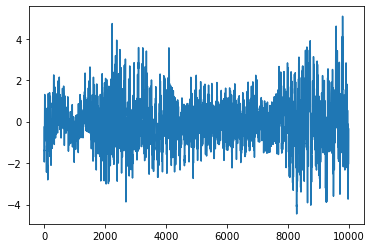

In [6]:
from src.DatasetTdoa20201016 import DatasetTdoa20201016
d = DatasetTdoa20201016()

In [27]:
d[0]

(array([[  2415616,   6207744,  12089344, ...,   3051264,   2141184,
            752384],
        [-43425024, -44532480, -43348736, ...,  20171520,  16007680,
          15063040]], dtype=int32),
 35.34451957101294)

In [14]:
import models.ResNet.model as modellib
#model = config_train.get_model()
#model = model.to(config_train.device)

model = torch.load("models/ResNet/checkpoints/musan_easy_25.pth")

In [8]:
from models.gcc_phat.gcc_phat import gcc_phat

model = gcc_phat()
for i in range(30):
    pred = model(X[i:i+1,:])[0]
#    plt.plot(pred.numpy())

    guess = pred.argmax()
    if guess > 5000:
        guess -= 10000

    print(guess.item())
    print(y[i].item())
    print("---")




IndexError: too many indices for tensor of dimension 1

In [9]:
#model = config_eval.get_model()
#model = torch.load("models/ResNet/checkpoints/musan_0.pth")
#import models.ResNet.model as modellib
#model = model.to(config_train.device)
from src.DatasetTdoa20201016 import DatasetTdoa20201016


d = DatasetTdoa20201016()





In [122]:
import configs.config_train as config_train
#model = config_train.get_model()
#model = model.to(config_train.device)
model = torch.load("models/ResNet/checkpoints/musan_big_30.pth")
model = model.to(config_train.device)



In [123]:
d.times["music_0010"].shape

(512,)

In [124]:
d.sounds["music_0010"].shape

(512, 12, 10000)

(0.0, 5.0)

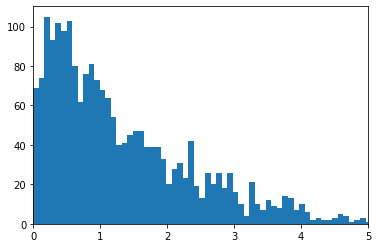

In [130]:
dl = torch.utils.data.DataLoader(d, batch_size=config_train.batch_size, shuffle=True)

X,y = next(iter(dl))
y = y + 500
X = X.float()
X, y = X.to(config_train.device), y.to(config_train.device)
pred = model(X)


# Compute accuracy bellow some threshold too
temp = (pred.argmax(dim=1) - y).abs() < config_train.inlier_threshold
#sum(temp)
a = (pred.argmax(dim=1) - y).abs().cpu().detach().numpy()

plt.hist(a,80);
plt.xlim(0,5)


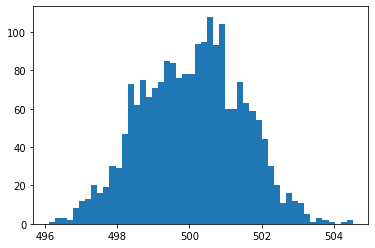

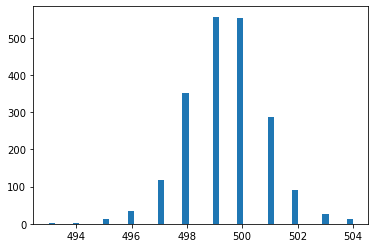

In [133]:
plt.hist(y.cpu().detach().numpy(),50)
plt.figure()
plt.hist(pred.argmax(dim=1).cpu().detach().numpy(),50);

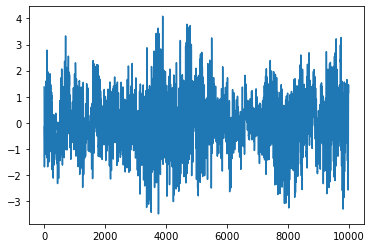

In [109]:
plt.plot(X[0,0].cpu())

In [28]:
import glob
import scipy.io.wavfile as wavfile
import pandas as pd

#e = glob.glob("data/tdoa_20201016/data/*")

#[i.split("/")[-1] for i in e]



In [253]:
class Dataset_tdoa_20201016(torch.utils.data.Dataset):

    # Take ~10s to initialize dataset
    def __init__(self,
            tdoa_20201016_path = os.path.join("data","tdoa_20201016"),
            recording_len = 10000,
            target_sampling_rate = 16000,
            overlap_ratio = 5/6, # 5/6 overlap between different windows
            cutoff_quiet = 1e7, 
            ):
        super().__init__()
        #tdoa_20201016 specific constants
        self.recorded_sampling_rate = recording_len
        self.target_sampling_rate = target_sampling_rate
        self.overlap_ratio = overlap_ratio
        self.cutoff_quiet = cutoff_quiet
        self.n_mics = 12
        self.recorded_sampling_rate = 96000
        usable_experiments = [
        'music_0010',
        'music_0012',
        'music_0011',
        'music_0008',
        'chirp_0004',
        'chirp_0002',
        'music_0014',
        'metronom_0022',
        'metronom_0021',
        'chirp_0001',
        'iregchirp_0006',
        'iregchirp_0007',
        'music_0009',
        'music_0015',
        ]
        usuable_gt_time = {
            'music_0010' : [7,63],
            'music_0012' : [7,69],
            'music_0011' : [7,65],
            'music_0008' : [7,49],
            'chirp_0004' : [4,45],
            'chirp_0002' : [4,30],
            'music_0014' : [12,82],
            'metronom_0022' : [28,41],
            'metronom_0021' : [6,26],
            'chirp_0001' : [0,47],
            'iregchirp_0006' : [5,55],
            'iregchirp_0007' : [6,60],
            'music_0009' : [8,65],
            'music_0015' : [8,79],
        }
        self.speed_of_sound = 343

        self.sounds = {}
        self.times = {}
        self.gt_toa = {}
        self.exp_lens = []
        self.exp_names = []

        for exp in usable_experiments[:3]:
            #exp = self.usable_experiments[10]
            exp_path = os.path.join(tdoa_20201016_path, "data", exp)

            # load sound
            exp_sounds = []
            for i in range(self.n_mics):
                fs, temp = wavfile.read(os.path.join(exp_path,"Track " + str(i+1) + ".wav"))
                exp_sounds.append(temp)
            exp_sounds = np.stack(exp_sounds)

            #load ground truth
            df = pd.read_csv(os.path.join(exp_path, "gt_positions.csv")) # Note time-column = 0 when audio-recordings started

            dims = ["x","y","z"]
            time = df["time"].to_numpy() # time = 0 correspond to start of sound-recording
            senders = df[["speaker" + "_" +dim for dim in dims]].to_numpy()
            receivers = np.zeros((self.n_mics,3))
            for i in range(self.n_mics):
                for j,dim in enumerate(["x","y","z"]):
                    temp = df["mic" + str(i+1) + "_" + dim]
                    receivers[i,j] = temp[temp.notnull()].median()


            if self.recorded_sampling_rate/target_sampling_rate - self.recorded_sampling_rate//target_sampling_rate == 0:
                downsampling_rate = self.recorded_sampling_rate//target_sampling_rate
                sample_shifts_between_windows = round((1 - overlap_ratio)*recording_len*downsampling_rate)
                sample_shifts_between_windows = 1 + sample_shifts_between_windows//downsampling_rate*downsampling_rate # make sample_shift_between_window be relative prime to downsampling_rate
                starts = np.arange(0,exp_sounds.shape[1]-recording_len*downsampling_rate,sample_shifts_between_windows)
                sound_windows = np.stack([exp_sounds[:,start:start+recording_len*downsampling_rate:downsampling_rate] for start in starts])
                time_windows = (starts + recording_len/2)/self.recorded_sampling_rate
                sender_windows = np.stack([np.interp(time_windows,time, senders[:,i]) for i in range(3)]).T
                gt_toa_windows = np.stack([np.linalg.norm(sender_windows - receivers[i,:],axis=1) for i in range(self.n_mics)]).T
                good_gt_idx = np.all(np.isfinite(gt_toa_windows),axis=1) # remove idx with nan as gt
                good_time_idx = (time_windows > usuable_gt_time[exp][0]) & (time_windows < usuable_gt_time[exp][1] ) #...and also remove windows outside of usuable_gt times
                has_sound_idx = sound_windows.std(axis=(1,2)) > cutoff_quiet
                # ...and check that sound is playing
                good_idx = good_gt_idx & good_time_idx & has_sound_idx
                self.sounds[exp] = sound_windows[good_idx]
                self.times[exp] = time_windows[good_idx]
                self.gt_toa[exp] = gt_toa_windows[good_idx]
                self.exp_lens.append(time_windows[good_idx].shape[0])
                self.exp_names.append(exp)
            else:
                raise Exception("Not implemented for non-integer downsampling yet")
        
        self.pair_idx_to_component_idx = []
        for i in range(self.n_mics):
            for j in range(i+1,self.n_mics):
                self.pair_idx_to_component_idx.append((i,j))
        self.n_pairs = len(self.pair_idx_to_component_idx) #(self.n_mics*(self.n_mics + 1))//2
        self.exp_lens = np.array(self.exp_lens)*self.n_pairs
        self.c_exp_lens = np.cumsum(self.exp_lens)
        self.n_windows = np.sum(self.exp_lens)

    def __getitem__(self, idx):
        # mic idx
        pair_idx = idx % self.n_pairs
        mic1,mic2 = self.pair_idx_to_component_idx[pair_idx]

        # experiment name
        exp_i = np.argmax(self.c_exp_lens < idx)
        exp = self.exp_names[exp_i]

        #idx inside the experiment
        idx_in_exp = idx - (self.exp_lens[exp_i - 1] if exp_i > 0 else 0)
        window_idx = idx_in_exp//self.n_pairs

        sound = np.stack(self.sounds[exp][window_idx,[mic1,mic2]],axis=0)
        tdoa = self.gt_toa[exp][window_idx, mic1] - self.gt_toa[exp][window_idx, mic2]
        return sound, tdoa*self.target_sampling_rate/self.speed_of_sound
        
    def __len__(self):
        return self.n_windows

d = DatasetTdoa20201016()


# sounds = {experiment_name : ndarray[window_idx, mic, recording_len] }
# times = {experiment_name : ndarray[window_idx]}
# gt_toa = {experiment_name : ndarray[window_idx, mic]}


# plt.figure(figsize=(12,6))
# plt.plot(time, senders)
# xs = plt.xlim()
# if exp in usuable_gt_time:
#     plt.figure(figsize=(12,6))
#     start_time, end_time = usuable_gt_time[exp]
#     idx = (time > start_time) & (time < end_time)
#     plt.plot(time[idx], senders[idx])
#     plt.xlim(xs)



In [287]:
d[np.random.randint(1000)]


(array([[-36147456, -41591040, -46304768, ...,    181248,    360704,
           1362176],
        [ -6005248,  -4192000,  -2875136, ...,   -451072,   -573440,
           -941568]], dtype=int32),
 26.43522090188467)

In [230]:
#plt.hist(sound_windows.std(axis=(1,2)))

a = np.array([1000,5000,8000])

np.argmax(1500 < a)

# print(exp)
# plt.figure(figsize=(20,8))
# plt.plot(time_windows, sound_windows.std(axis=(1,2)),'.')
# plt.plot(time_windows[good_idx], sound_windows[good_idx].std(axis=(1,2)),'.')


1